In [ ]:
"""
MNIST Neural Network Training with Custom Optimizers
Course: Optimization Methods
Assignment: Implement and Compare Custom Optimizers with Adam

This code demonstrates:
1. Loading MNIST dataset
2. Simple feedforward neural network architecture
3. Adam optimizer implementation as a class
4. Framework for students to implement their own optimizer
5. Training loop with accuracy and loss tracking
6. Visualization of results
"""

import numpy as np
import matplotlib.pyplot as plt

# ===================================================================
# PART 1: NEURAL NETWORK ARCHITECTURE
# ===================================================================

class SimpleNN:
    """
    Simple feedforward neural network with one hidden layer.
    Architecture: Input (784) -> Hidden (128) -> Output (10)
    """

    def __init__(self, input_size=784, hidden_size=128, output_size=10):
        self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2.0 / input_size)
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(2.0 / hidden_size)
        self.b2 = np.zeros((1, output_size))

        self.params = {'W1': self.W1, 'b1': self.b1,
                       'W2': self.W2, 'b2': self.b2}
        self.cache = {}

    def relu(self, Z):
        return np.maximum(0, Z)
    def relu_derivative(self, Z):
        return (Z > 0).astype(float)
    def softmax(self, Z):
        exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
        return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)
    def forward(self, X):
        self.cache['X'] = X
        self.cache['Z1'] = X @ self.W1 + self.b1
        self.cache['A1'] = self.relu(self.cache['Z1'])
        self.cache['Z2'] = self.cache['A1'] @ self.W2 + self.b2
        self.cache['A2'] = self.softmax(self.cache['Z2'])
        return self.cache['A2']
    def backward(self, y_true):
        m = y_true.shape[0]
        dZ2 = self.cache['A2'] - y_true
        dW2 = (self.cache['A1'].T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m
        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(self.cache['Z1'])
        dW1 = (self.cache['X'].T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m
        return {'W1': dW1, 'b1': db1, 'W2': dW2, 'b2': db2}
    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)


# ===================================================================
# PART 2: OPTIMIZER BASE CLASS
# ===================================================================


class Optimizer:
    """
    Base class for optimizers.
    Students should inherit from this class to implement their own optimizer.
    """
    def __init__(self, learning_rate=0.001):
        self.learning_rate = learning_rate
        self.t = 0  # Time step

    def update(self, params, grads, Xb=None, yb=None):
        raise NotImplementedError("Subclasses must implement update method")


# ===================================================================
# PART 3: ADAM OPTIMIZER IMPLEMENTATION
# ===================================================================


class Adam(Optimizer):
    """
    Adam optimizer (Adaptive Moment Estimation).
    Reference: Kingma & Ba (2015)
    """
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {} # First moment
        self.v = {} # Second moment

    def update(self, params, grads, Xb=None, yb=None):
        if len(self.m) == 0:
            for key in params:
                self.m[key] = np.zeros_like(params[key])
                self.v[key] = np.zeros_like(params[key])
        self.t += 1
        for key in params:
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            v_hat = self.v[key] / (1 - self.beta2 ** self.t)
            params[key] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)


class MGD(Optimizer):
    """
    Momentum Gradient Descent optimizer.
    """
    def __init__(self, learning_rate=0.001, gamma=0.9):
        super().__init__(learning_rate)
        self.gamma = gamma
        self.m = {}
        
    def update(self, params, grads, Xb=None, yb=None):
        if len(self.m) == 0:
            for key in params:
                self.m[key] = np.zeros_like(params[key])
        for key in params:
            self.m[key] = self.gamma * self.m[key] + self.learning_rate * grads[key]
            params[key] -= self.m[key]
class RMSProp(Optimizer):
    """
    RMSProp optimizer.
    """
    def __init__(self, learning_rate=0.001, beta=0.9, epsilon=1e-8):
        super().__init__(learning_rate)
        self.beta = beta
        self.epsilon = epsilon
        self.v = {}
        
    def update(self, params, grads, Xb=None, yb=None):
        if len(self.v) == 0:
            for key in params:
                self.v[key] = np.zeros_like(params[key])
        for key in params:
            self.v[key] = self.beta * self.v[key] + (1 - self.beta) * (grads[key] ** 2)
            params[key] -= self.learning_rate * grads[key] / (np.sqrt(self.v[key]) + self.epsilon)

In [ ]:

# ===================================================================
# PART 4: TEMPLATE FOR CUSTOM OPTIMIZER (FOR STUDENTS)
# ===================================================================

# Updated Momemtum Gradient Descent with Stability Feedback
# Stability Feedback Adam Optimizer - SFAO
class UMG(Optimizer):
    def __init__(self, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8, model=None):
        super().__init__(learning_rate)
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.m = {}
        self.v = {}
        self.t = 0
        self.model = model
        self.prev_diff = {}
    
    def update(self, params, grads, Xb=None, yb=None):
        if not self.m:
            for key in params:
                self.m[key] = np.zeros_like(params[key])
                self.v[key] = np.zeros_like(params[key])
                self.prev_diff[key] = np.inf

        self.t += 1

        for key in params:
            # normal Adam-style update
            self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * grads[key]
            self.v[key] = self.beta2 * self.v[key] + (1 - self.beta2) * (grads[key] ** 2)
            m_hat = self.m[key] / (1 - self.beta1 ** self.t)
            v_hat = self.v[key] / (1 - self.beta2 ** self.t)

            params[key] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)

            # stability feedback
            if self.model:
                new_pred = self.model.forward(Xb)
                new_grad = self.model.backward(yb)

                diff = new_grad[key] - grads[key]
                diff_norm = np.linalg.norm(diff)

                if diff_norm < self.prev_diff[key]:
                    # good direction -> reinforce but not explode
                    scale = 1
                else:
                    # bad direction -> dampen update
                    scale = 0.5

                # adjust second moment with scale
                self.m[key] = self.beta1 * self.m[key] + (1 - self.beta1) * (grads[key]) * scale

                self.prev_diff[key] = diff_norm

In [ ]:

# ===================================================================
# PART 5: UTILITY FUNCTIONS
# ===================================================================


def load_mnist_data(subset_size=10000):
    try:
        from sklearn.datasets import fetch_openml
        from sklearn.model_selection import train_test_split

        print("Loading MNIST dataset...")
        mnist = fetch_openml('mnist_784', version=1, parser='auto', as_frame=False)
        X, y = mnist.data[:subset_size], mnist.target[:subset_size].astype(int)
        X = X.astype(np.float32) / 255.0
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        print(f"Training samples: {X_train.shape[0]}")
        print(f"Test samples: {X_test.shape[0]}")
        return X_train, X_test, y_train, y_test
    except Exception as e:
        print(f"Dataset load error: {e}")
        n_train, n_test = 8000, 2000
        X_train = np.random.rand(n_train, 784).astype(np.float32)
        X_test = np.random.rand(n_test, 784).astype(np.float32)
        y_train = np.random.randint(0, 10, n_train)
        y_test = np.random.randint(0, 10, n_test)
        return X_train, X_test, y_train, y_test

def one_hot_encode(y, num_classes=10):
    one_hot = np.zeros((y.shape[0], num_classes))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

def compute_loss(predictions, y_true):
    predictions = np.clip(predictions, 1e-10, 1 - 1e-10)
    loss = -np.sum(y_true * np.log(predictions)) / y_true.shape[0]
    return loss

def compute_accuracy(predicted_labels, y_true):
    return np.mean(predicted_labels == y_true) * 100

def create_mini_batches(X, y, batch_size=32):
    m = X.shape[0]
    batches = []
    order = np.random.permutation(m)
    X_shuf = X[order]
    y_shuf = y[order]
    for k in range(m // batch_size):
        Xb = X_shuf[k*batch_size:(k+1)*batch_size]
        yb = y_shuf[k*batch_size:(k+1)*batch_size]
        batches.append((Xb, yb))
    if m % batch_size != 0:
        Xb = X_shuf[(m//batch_size)*batch_size:]
        yb = y_shuf[(m//batch_size)*batch_size:]
        batches.append((Xb, yb))
    return batches


# ===================================================================
# PART 6: TRAINING AND VISUALIZATION FUNCTIONS
# ===================================================================


def train_model(model, optimizer, X_train, y_train, X_test, y_test, epochs=20, batch_size=64):
    hist = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    y_train_oh = one_hot_encode(y_train)
    y_test_oh = one_hot_encode(y_test)
    for epoch in range(epochs):
        minibatches = create_mini_batches(X_train, y_train_oh, batch_size)
        for Xb, yb in minibatches:
            pred = model.forward(Xb)
            grads = model.backward(yb)
            optimizer.update(model.params, grads, Xb, yb)
        train_pred = model.forward(X_train)
        test_pred = model.forward(X_test)
        hist['train_loss'].append(compute_loss(train_pred, y_train_oh))
        hist['test_loss'].append(compute_loss(test_pred, y_test_oh))
        hist['train_acc'].append(compute_accuracy(model.predict(X_train), y_train))
        hist['test_acc'].append(compute_accuracy(model.predict(X_test), y_test))
        print(f"Epoch {epoch+1}/{epochs} - Train acc: {hist['train_acc'][-1]:.2f}%, Test acc: {hist['test_acc'][-1]:.2f}%")
    return hist

def plot_training_history(histories):
    plt.figure(figsize=(24,12))
    for name, hist in histories.items():
        plt.plot(hist['test_acc'], label=f"{name} Test Acc")
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.yticks(range(50, 101, 2))
    plt.xticks(range(0, 20, 1))
    plt.ylim(50, 100)
    plt.grid(visible=True)
    plt.title("Test Accuracy per Optimizer")
    plt.show()

Loading MNIST dataset...
Training samples: 8000
Test samples: 2000


In [ ]:

# ===================================================================
# PART 7: MAIN EXECUTION (RUN TRAINING)
# ===================================================================

histories = {}
X_train, X_test, y_train, y_test = load_mnist_data(subset_size=10000)


In [ ]:

model_adam = SimpleNN()
optimizer_adam = Adam(learning_rate=0.001)
hist_adam = train_model(model_adam, optimizer_adam, X_train, y_train, X_test, y_test)
histories['Adam'] = hist_adam
print("Adam training completed.")

model_mgd = SimpleNN()
optimizer_mgd = MGD(learning_rate=0.001, gamma=0.9)
hist_mgd = train_model(model_mgd, optimizer_mgd, X_train, y_train, X_test, y_test)
histories['MGD'] = hist_mgd
print("MGD training completed.")

model_rmsprop = SimpleNN()
optimizer_rmsprop = RMSProp(learning_rate=0.001, beta=0.9)
hist_rmsprop = train_model(model_rmsprop, optimizer_rmsprop, X_train, y_train, X_test, y_test)
histories['RMSProp'] = hist_rmsprop
print("RMSProp training completed.")

model_cust4 = SimpleNN()
optimizer_cust4 = CustomOptimizer4(learning_rate=0.01, model=model_cust4)
hist_cust4 = train_model(model_cust4, optimizer_cust4, X_train, y_train, X_test, y_test)
histories['Custom 4 (Stability Feedback)'] = hist_cust4
print("Custom optimizer 4 training completed.")

Epoch 1/20 - Train acc: 90.95%, Test acc: 90.95%
Epoch 2/20 - Train acc: 93.06%, Test acc: 92.50%
Epoch 3/20 - Train acc: 95.23%, Test acc: 93.70%
Epoch 4/20 - Train acc: 96.26%, Test acc: 94.40%
Epoch 5/20 - Train acc: 96.84%, Test acc: 94.35%
Epoch 6/20 - Train acc: 97.41%, Test acc: 94.40%
Epoch 7/20 - Train acc: 98.06%, Test acc: 95.10%
Epoch 8/20 - Train acc: 98.45%, Test acc: 95.10%
Epoch 9/20 - Train acc: 98.72%, Test acc: 95.20%
Epoch 10/20 - Train acc: 99.02%, Test acc: 95.05%
Epoch 11/20 - Train acc: 99.28%, Test acc: 95.00%
Epoch 12/20 - Train acc: 99.42%, Test acc: 95.25%
Epoch 13/20 - Train acc: 99.54%, Test acc: 95.30%
Epoch 14/20 - Train acc: 99.72%, Test acc: 95.70%
Epoch 15/20 - Train acc: 99.65%, Test acc: 95.25%
Epoch 16/20 - Train acc: 99.88%, Test acc: 95.55%
Epoch 17/20 - Train acc: 99.85%, Test acc: 95.30%
Epoch 18/20 - Train acc: 99.94%, Test acc: 95.50%
Epoch 19/20 - Train acc: 99.98%, Test acc: 95.65%
Epoch 20/20 - Train acc: 99.99%, Test acc: 95.70%
Adam trai

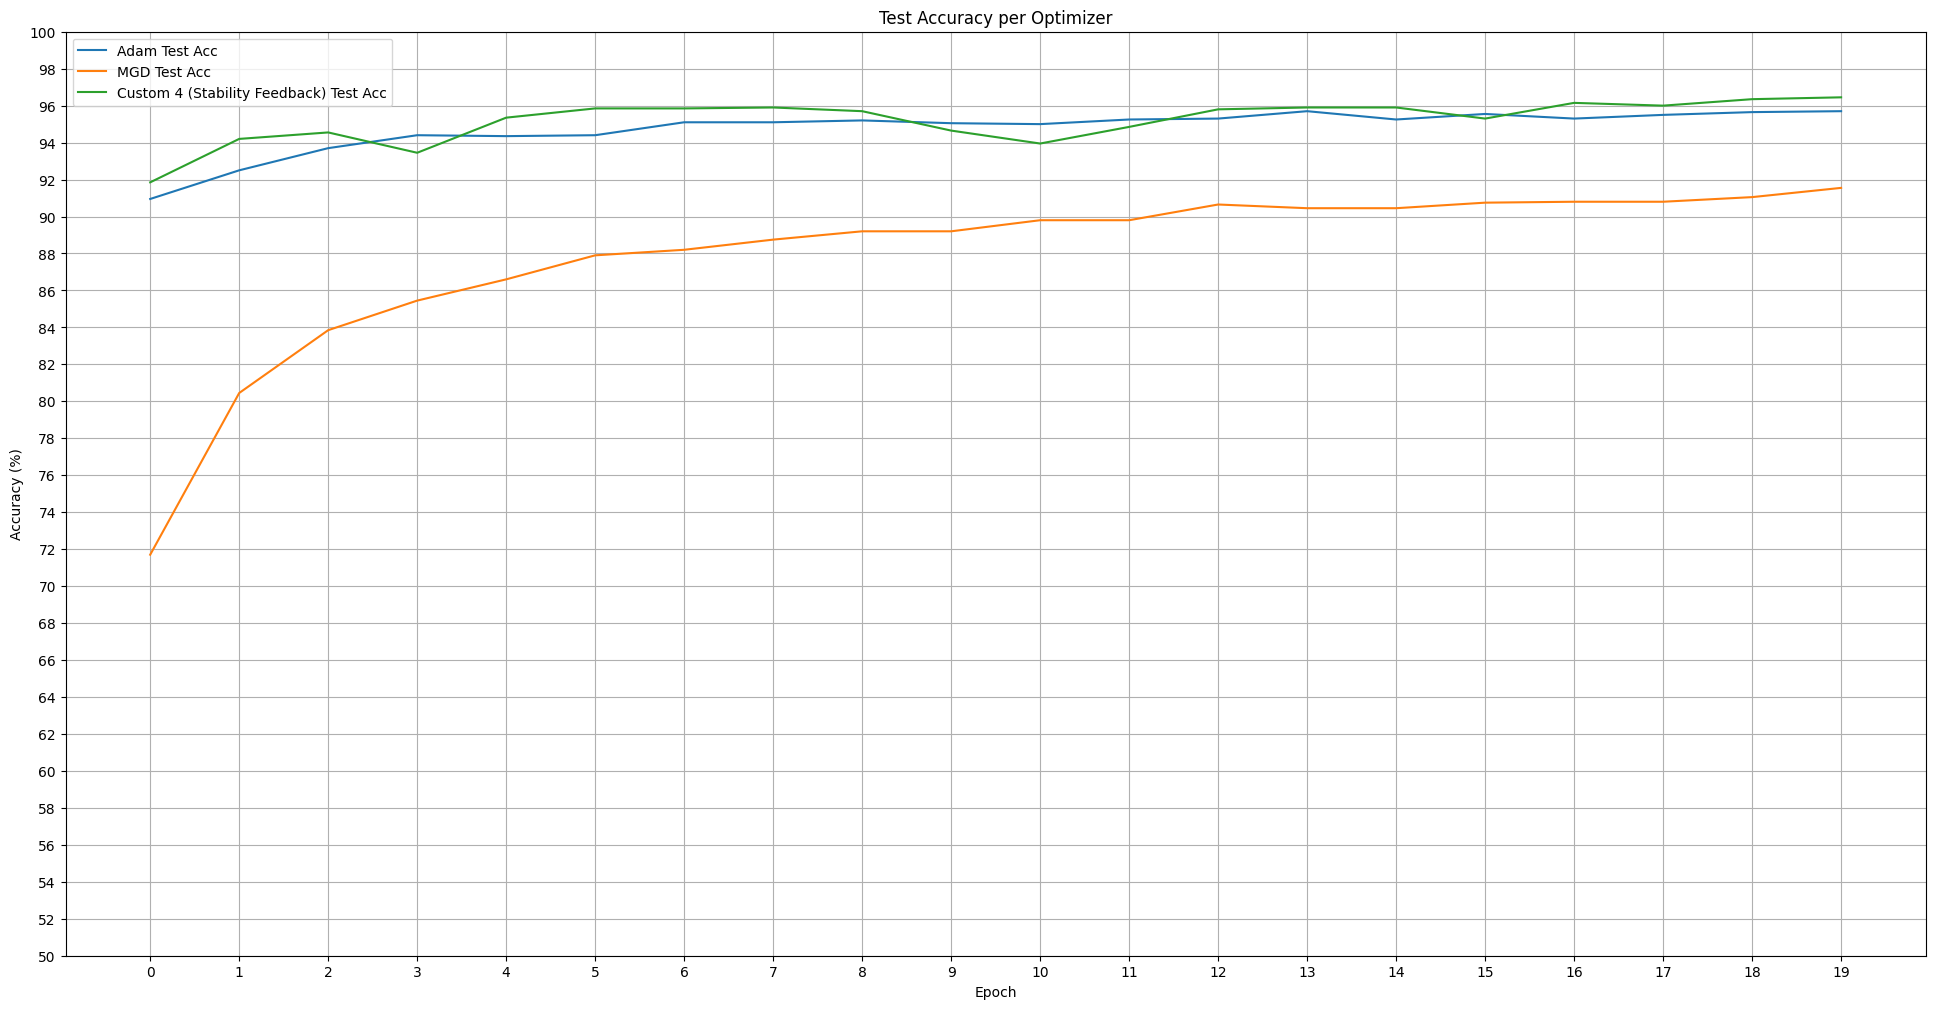

In [34]:
plot_training_history(histories)


In [ ]:
def plot_loss(histories):
    plt.figure(figsize=(24,12))
    for name, hist in histories.items():
        plt.plot(hist['test_loss'], label=f"{name} Test Loss")
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.yticks(np.linspace(0, 2, 11))
    plt.xticks(range(0, 20, 1))
    plt.ylim(0, 2)
    plt.grid(visible=True)
    plt.title("Test Accuracy per Optimizer")
    plt.show()

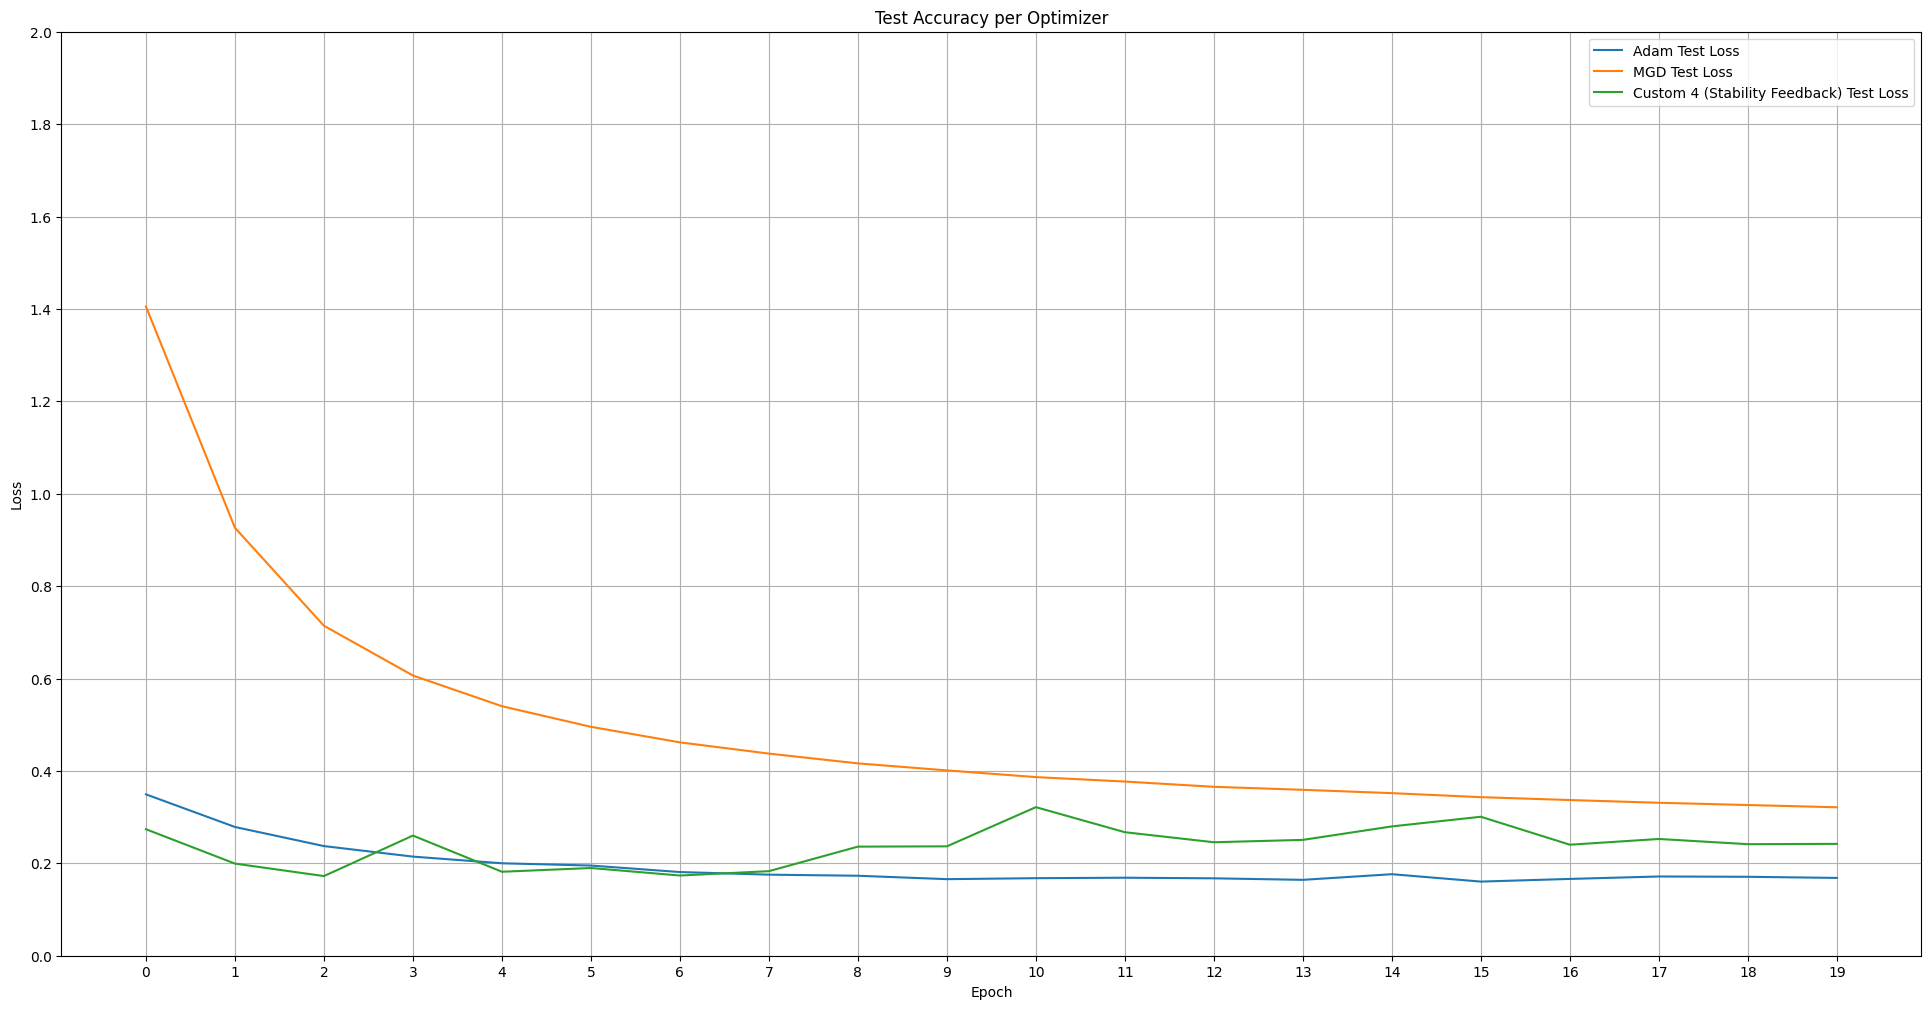

In [35]:
plot_loss(histories)